In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Copy the uploaded zip file in google drive to colab session for faster processing.
!cp -r '/content/drive/My Drive/notebooks/Messidor.zip' '/'
!cp -r '/content/drive/My Drive/notebooks/model-00068-0.47521-0.52819.h5' '/'
#Unzip the data in  colab session for faster processing.
!unzip '/Messidor.zip' -d '/'

Archive:  /Messidor.zip
   creating: /Messidor/IMAGES/
  inflating: /Messidor/IMAGES/20051020_43808_0100_PP.png  
  inflating: /Messidor/IMAGES/20051020_43832_0100_PP.png  
  inflating: /Messidor/IMAGES/20051020_43882_0100_PP.png  
  inflating: /Messidor/IMAGES/20051020_43906_0100_PP.png  
  inflating: /Messidor/IMAGES/20051020_44261_0100_PP.png  
  inflating: /Messidor/IMAGES/20051020_44284_0100_PP.png  
  inflating: /Messidor/IMAGES/20051020_44338_0100_PP.png  
  inflating: /Messidor/IMAGES/20051020_44349_0100_PP.png  
  inflating: /Messidor/IMAGES/20051020_44400_0100_PP.png  
  inflating: /Messidor/IMAGES/20051020_44431_0100_PP.png  
  inflating: /Messidor/IMAGES/20051020_44598_0100_PP.png  
  inflating: /Messidor/IMAGES/20051020_44636_0100_PP.png  
  inflating: /Messidor/IMAGES/20051020_44692_0100_PP.png  
  inflating: /Messidor/IMAGES/20051020_44714_0100_PP.png  
  inflating: /Messidor/IMAGES/20051020_44762_0100_PP.png  
  inflating: /Messidor/IMAGES/20051020_44782_0100_PP.png  
 

In [3]:
import pandas as pd
import cv2

In [4]:
# messidor_data.csv has 1748 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/Messidor/messidor_data.csv', delimiter=',')
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1748 rows and 4 columns


In [5]:
df1['dr'] = [1 if x > 0 else 0 for x in df1['adjudicated_dr_grade']] 

In [6]:
df1.head()

,image_id,adjudicated_dr_grade,adjudicated_dme,adjudicated_gradable,dr
0,20051020_43808_0100_PP.png,0.0,0.0,1,0
1,20051020_43832_0100_PP.png,1.0,0.0,1,1
2,20051020_43882_0100_PP.png,1.0,0.0,1,1
3,20051020_43906_0100_PP.png,2.0,1.0,1,1
4,20051020_44261_0100_PP.png,0.0,0.0,1,0


In [7]:
y = 150  # height of the image
z = 150  # Width of the image
def load_validation_dataset(source_path,image_data):

  ls = len(image_data)

  test_img,test_label = list(),list()

  for index in range(20):
    
    image_path = source_path+image_data[index][0]
    label = image_data[index][4]
    img = cv2.imread(image_path)
 
    if(img is not None and  (img.shape[0] > 0) and (img.shape[1] > 0)):
      img = cv2.resize(img, (z,y), interpolation=cv2.INTER_LINEAR)

      test_img.append(img)  
      test_label.append(label)
    # convert to numpy array
   
  return test_img,test_label

  
#batch  generator
def generator(source_path, batch_size,image_data,label_data):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)

    ls = len(image_data)

    t = image_data
    num_batches = ls // batch_size;
    while True:        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,1)) # batch_labels is the one hot representation of the output
            
            for index in range(batch_size): # iterate over the batch_size
                               
                #image_path = source_path+t[(batch_size*batch) + index][0]+".jpg"             
                #print("reading train :: ",image_path)  
                #org_image =  cv2.imread(image_path) # read all the images in the folder
                
                org_image = image_data[(batch_size*batch) + index]
                #org_image = cv2.resize(org_image, (z,y), interpolation=cv2.INTER_LINEAR)

                h, w, c = org_image.shape
                if (h < y) or (w < z):
                  print(org_image.shape)
                #org_image_gray = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)
                #final_image = clahe.apply(org_image_gray)
                #final_image = cv2.medianBlur(final_image,3)                    
                #final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)    

                final_image = (org_image / 127.5) - 1.0 

                batch_data[index,:,:,0] = final_image[:,:,0]
                batch_data[index,:,:,1] = final_image[:,:,1]
                batch_data[index,:,:,2] = final_image[:,:,2]

                
                batch_labels[index, 0] = label_data[(batch_size*batch) + index]
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        #Check if there are any remaining folders to be processed
        if len(t) % batch_size != 0 : 
            start = (batch_size*num_batches)
            end = len(t)
            batch_data = np.zeros((end-start,y,z,3))
            batch_labels = np.zeros((end-start,1))
            for index,id in enumerate(range(start , end)): # iterate over the batch_size
                
                
                #image_path =  source_path+imahe_data[id][0]+".jpg"    
                   
                #org_image =  cv2.imread(image_path) # read all the images in the folder

                org_image = image_data[id]
                #org_image = cv2.resize(org_image, (z,y), interpolation=cv2.INTER_LINEAR)

                h, w, c = org_image.shape
                if (h < y) or (w < z):
                  print(org_image.shape)
                #org_image_gray = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)
                #final_image = clahe.apply(org_image_gray)
                #final_image = cv2.medianBlur(final_image,3)                    
                #final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)      
                
                final_image = (org_image / 127.5) - 1.0 

                batch_data[index,:,:,0] = final_image[:,:,0]
                batch_data[index,:,:,1] = final_image[:,:,1]
                batch_data[index,:,:,2] = final_image[:,:,2]

                batch_labels[index, 0] = label_data[id]      

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do      

In [8]:
batch_size = 16
val_source_path = '/Messidor/IMAGES/'
val_img,val_l = load_validation_dataset(val_source_path,df1.to_numpy())

print(len(val_img))

20


In [16]:
val_generator = generator(val_source_path ,batch_size,val_img,val_l)

num_val_sequences = len(val_img)
if (num_val_sequences%batch_size) == 0:
    steps_per_epoch = int(num_val_sequences/batch_size)
else:
    steps_per_epoch = (num_val_sequences//batch_size) + 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


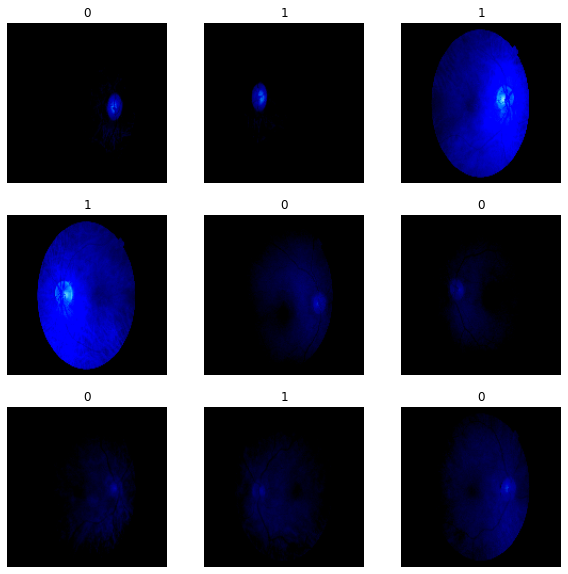

In [10]:
import numpy as np

import matplotlib.pyplot as plt
images, labels = next(val_generator)
   
plt.figure(figsize=(10, 10))

for i in range(9):
    first_image = images[i]
    img = ((first_image * 127.5)+1).astype(np.int32)
    ax = plt.subplot(3, 3, i + 1)
    #augmented_image = data_augmentation(
    #    tf.expand_dims(first_image, 0), training=True
    #)
    plt.imshow(first_image)
    plt.title(int(labels[i]))
    plt.axis("off")

In [17]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('/model-00019-0.47521-0.52819.h5')
# summarize model.
model.summary()
# load dataset
# evaluate the model
score = model.evaluate(val_generator, verbose=1,steps=steps_per_epoch )
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________
2/2 [==============================] - 3s 384ms/step - loss: 0.9144 - binary_accuracy: 0.4000
binary_accuracy: 